# Feature selection in Random Forest
Variable and feature selection have become the focus of much research in areas of application for which datasets with tens or hundreds of thousands of variables are available.

Variable selection has multiple goals: improving the prediction performance of the predictors, providing faster and more cost-effective predictors, and providing a better understanding of the underlying process that generated the data.

Random Forests are frequently applied as they achieve a high prediction accuracy and have the ability to identify informative variables. They provide variable importance measures to rank predictors according to their predictive power. If building a prediction model is the main goal of a study, often a minimal set of variables with good prediction performance is selected.

## Goals
The goal of this project is to experiment with different approaches for feature selection using Random Forests, both with simulated data and with a real dataset.

The methods that will be tested are:
* standard Random Forests
* Random Forests with permutation
* Random Forests with recursive feature elimination (RFE)

### Standard Random Forests
Feature selection in scikit-learn standard Random Forests approach is done using the Gini Importance index, or Mean Decrease in impurity (MDI). MDI counts the times a feature is used to split a node, weighted by the number of samples it splits.

It is defined as the total decrease in node impurity (weighted by the probability of reaching that node - which is approximated by the proportion of samples reaching that node) averaged over all trees of the ensemble. At each split in each tree, the improvement in the split-criterion is the importance measure attributed to the splitting variable, and is accumulated over all the trees in the forest separately for each variable.

Gini index is calculated as

$$\sum_{i=i}^{n_c} p_i (1-p_i)$$

Where $n_c$ is the number of classes in the target variable and $p_i$ is the ratio of this class. 

The importance is then calculated as

$$I = G_{parent} - G_{split1} - G_{split2}$$

averaged over all splits in the forest involving the predictor in question.

_For ease of readability, details on Permutation and RFE approach are given later in this notebook_

In [16]:
# generic imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

In [17]:
%matplotlib inline
sns.set(palette='pastel')

## Simulated data with standard Random Forests approach
The first batch of tests are done starting from a set of simulated data.

Lets first create the helper function that will generate the simulated data via `make_classification`, fit a random forest classifier and plot the data.

In [253]:
def rf_test(n_trees, n_samples, row_trees=False, feat = [10,200,500]):
    # feat = nr of features
    # number of redundant features
    rfeat=[0,10,10]

    # cycle through the number of trees, samples and features
    for k, t in enumerate(n_trees):
        for j, n in enumerate(n_samples):
            for i in range(0,len(feat)):
                # create and fit the rf classificator
                X, y = make_classification(n_samples=n, n_features=feat[i], n_informative=6, n_redundant=rfeat[i], random_state=0, shuffle=False)
                rf = RandomForestClassifier(n_estimators=t, n_jobs=-1, oob_score=False, random_state=0)
                rf.fit(X, y)
                # name of the features
                col = ['f'+str(i) for i in range(0,feat[i])]
                # retrieve the values of each feature importance of all the trees
                feat_importance = [t.feature_importances_ for t in rf.estimators_]
                df = pd.DataFrame(columns=col, data=feat_importance)
                # limit the max nr of columns to show in the plot
                maxcols=min(df.shape[1], 25)
                
                # plot
                row = k if row_trees else j
                sns.boxplot(data=df.iloc[:, :maxcols], ax=axis[row][i])
                plt.text(0.6, 0.8,'feat={}\nredundant feat={}'.format(feat[i], rfeat[i]), bbox=dict(facecolor='white', alpha=0.8), transform = axis[row][i].transAxes)

Just as an example lets explore the correlation matrix of the features of 2 simulated datasets with respectively 0 and 10 redundant features. The plots show this correlation very clearly.

Text(0.5,1,'6 informative feat - 10 redundant - 4 uncorrelated')

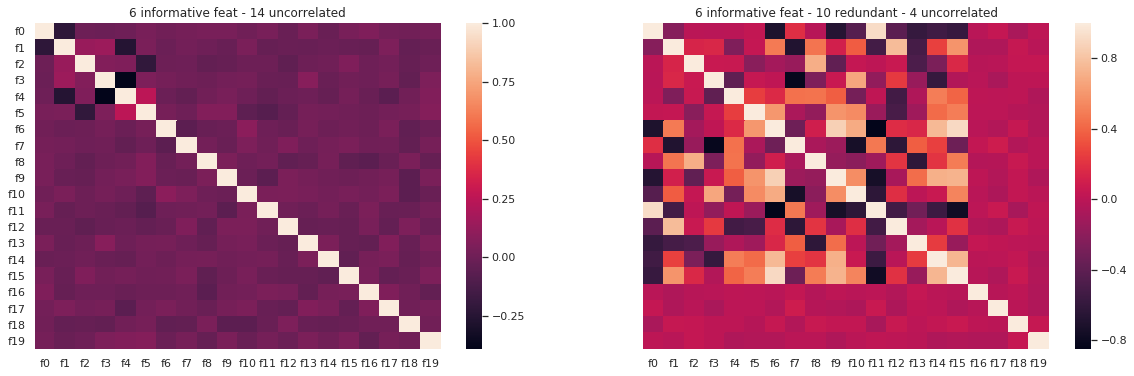

In [254]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=6, n_redundant=0, random_state=0, shuffle=False)
Xr, yr = make_classification(n_samples=1000, n_features=20, n_informative=6, n_redundant=10, random_state=0, shuffle=False)

col = ['f'+str(i) for i in range(0,20)]
df = pd.DataFrame(columns=col, data=X)
df_redundant = pd.DataFrame(columns=col, data=Xr)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6))
sns.heatmap(df.corr(), ax=ax1)
ax1.set_title('6 informative feat - 14 uncorrelated')
sns.heatmap(df_redundant.corr(), ax=ax2)
ax2.set_title('6 informative feat - 10 redundant - 4 uncorrelated')

As a first test lets try a setup where the number of trees of the Random Forest classifier is kept fixed to 10, while the number of samples (n) and the number of features (p) is changed.

In the following examples only 6 features are informative.

In the following plots, the first column has 10 features and none of them are redundant (redundant features are created as linear combination of the informative ones). The second column of plots represent a dataset with 200 features of which 10 are redundant while the last column has 500 features of which 10 are redundant.

The first row represents a dataset with 1000 samples, while the second row has 10000 samples.

Overall the most difficult task is represented by the top right plot, where the number of features is very high, although not bigger than the number of samples.

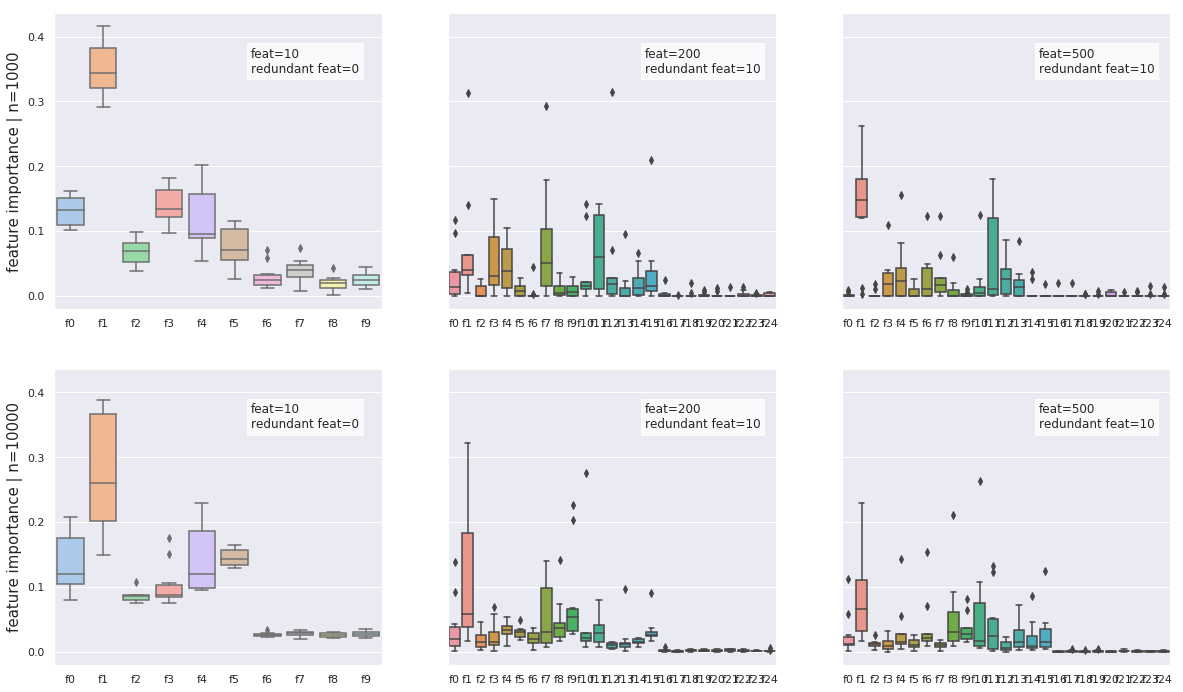

In [256]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, sharey=True, figsize=(20, 12))
axis = [[ax1, ax2, ax3], [ax4, ax5, ax6]]
n_samples=[1000, 10000]
n_trees=[10]

rf_test(n_trees, n_samples)
for i,n in enumerate(n_samples):
    axis[i][0].set_ylabel('feature importance | n={}'.format(n), rotation=90, size=15)

Analyzing the above plots it is clear how the first column represent the easiest task (no redundant features and $n >> p$) and the 6 informative features are easily spotted. This is especially evident in the dataset with 10000 samples.

As the number of features increases this approach is able to detect the non-informative features which have very low variance and mean value, but it's not able to distinguish between the informative and redundant ones.

Overall having a bigger sample size helps to decrease the variance of the feature importance values among the trees, as it was expected.

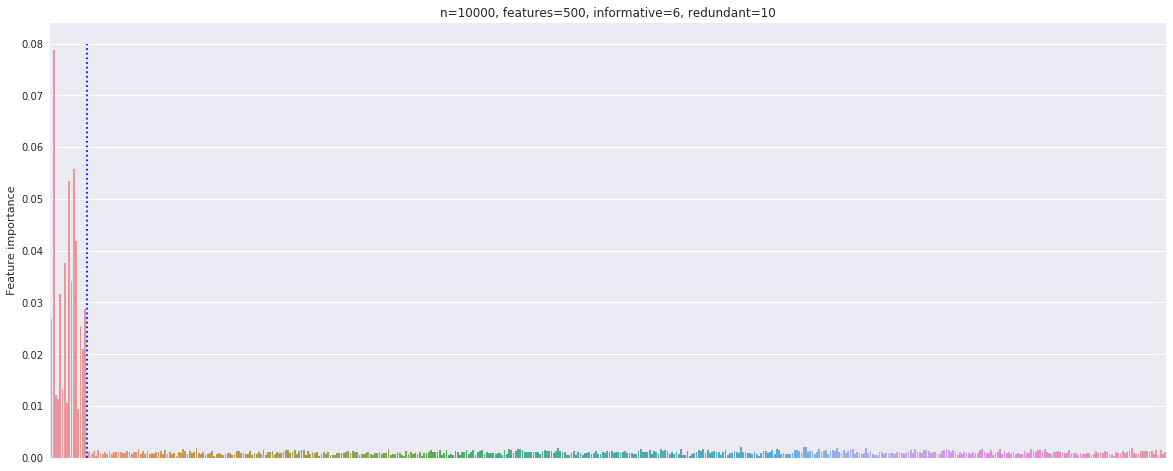

In [60]:
# reproduce the bottom right example of the previous grid of plots
X, y = make_classification(n_samples=10000, n_features=500, n_informative=6, n_redundant=10, random_state=0, shuffle=False)
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, oob_score=False, random_state=0)
rf.fit(X, y)

col = ['f'+str(i) for i in range(0,500)]
fig, ax = plt.subplots(1,1, figsize=(20, 8))
sns.barplot(x=col, y=rf.feature_importances_, ax=ax)
ax.xaxis.set_ticklabels([])
ax.set_ylabel('Feature importance')
ax.set_title('n=10000, features=500, informative=6, redundant=10')
# plot 16 features separator
ax.vlines(x=16, ymin=0.0, ymax=0.08, color='b', linestyles='dotted')

Since in the previous plots only the first 25 features where shown, the above plot shows the value of the feature importances referred to all the 500 features averaged among the 10 trees of the Random Forest. As it was expected, the first 16 features have significantly higher value compared to all the other non-informative features.

Lets try to follow the same procedure as above, but keeping fixed the number of samples to 10000 and varying the number of trees of the Random Forest classifier.

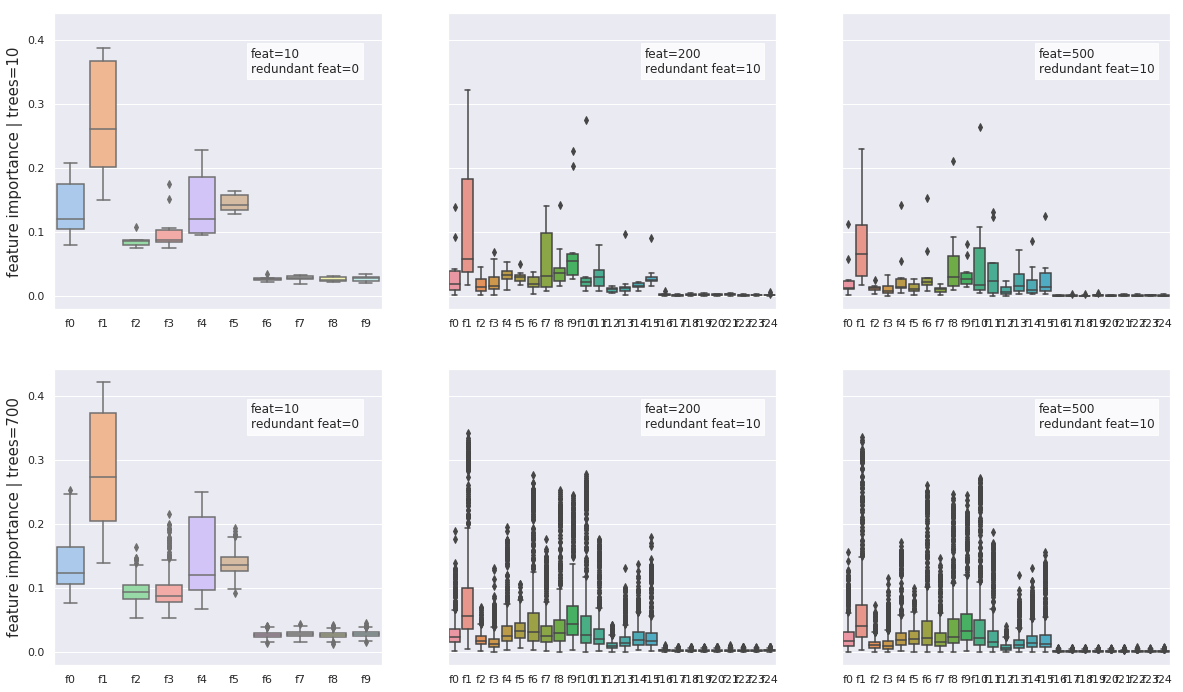

In [257]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, sharey=True, figsize=(20, 12))
axis = [[ax1, ax2, ax3], [ax4, ax5, ax6]]
n_samples=[10000]
n_trees=[10, 700]

rf_test(n_trees, n_samples, True)
for i,n in enumerate(n_trees):
    axis[i][0].set_ylabel('feature importance | trees={}'.format(n), rotation=90, size=15)

As far as the variance is concerned, in the case with a higher number of trees, the boxplots shows a shorter interquantile range for the relevant features, which indicates a lower variance, however there are a lot more outliers.

It appears that the mean value of the feature importance will be affected as well, but it's difficult to judge from the above boxplots, so lets try to isolate this and measure the improvement in the 2 cases, considering the most difficult case, where the number of features is 500.

In [258]:
# create the sample dataset
X, y = make_classification(n_samples=10000, n_features=500, n_informative=6, n_redundant=10, random_state=0, shuffle=False)

# create and fit the 2 rf classifiers with 10 and 700 trees
rf_small = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)
rf_small.fit(X, y)

rf_big = RandomForestClassifier(n_estimators=700, n_jobs=-1, random_state=0)
rf_big.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=700, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

Text(0,0.5,'Features importance')

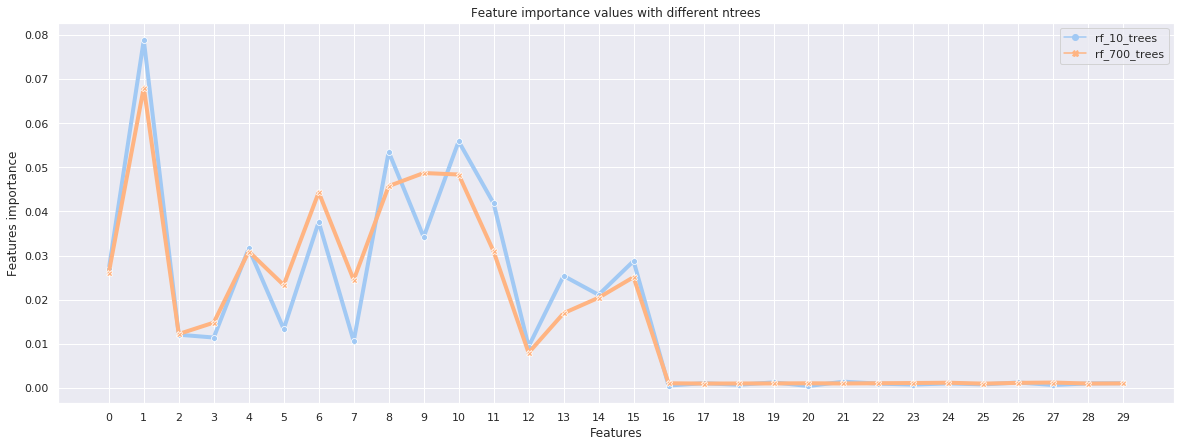

In [265]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))

# create the dataframe with the mean feature importance values
data = {
    'rf_10_trees': rf_small.feature_importances_,
    'rf_700_trees': rf_big.feature_importances_
}
df = pd.DataFrame(data=data)

# show only the first 30 features for readability
ax.set_xticks(range(0, 30))
sns.lineplot(data=df.iloc[:30, :], dashes=False, markers=True, ax=ax, lw=4)
ax.set_title('Feature importance values with different ntrees')
ax.set_xlabel('Features')
ax.set_ylabel('Features importance')

By plotting the value of the feature importances in the 2 examples, with `rf_700_trees` having 700 trees and `rf_10_trees` having only 10 trees it is possible to see that there is not much difference in the importance values. This could be an indication that the number of trees does not significantly affect the goodness of the feature selection process.

One last example that is interesting to analyse is the situation where the number of features is bigger than the number of samples. This is a frequent scenario in the medical field.

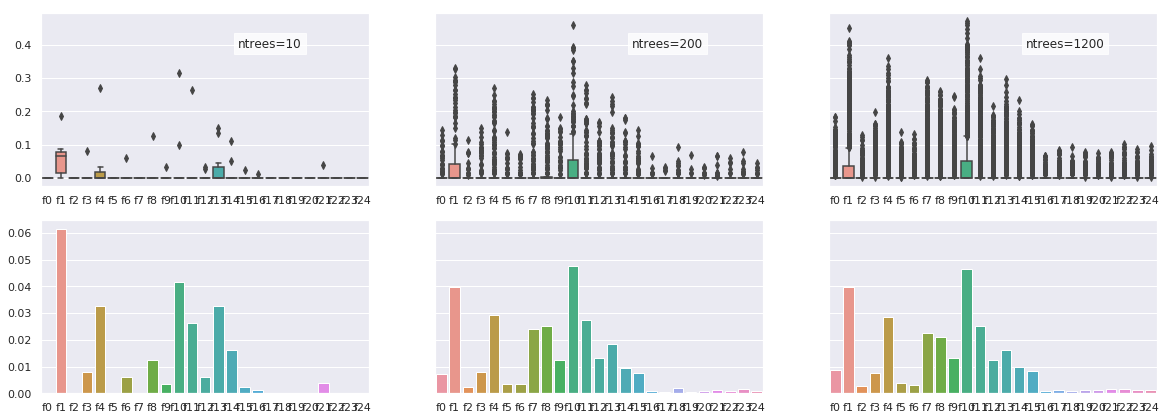

In [29]:
fig, [[ax1, ax2, ax3], [ax4, ax5, ax6]] = plt.subplots(2, 3, sharey='row', figsize=(20, 7))
axis = [[ax1, ax2, ax3], [ax4, ax5, ax6]]
n_trees=[10, 200, 1200]

for k, t in enumerate(n_trees):
    # create and fit the rf classificator
    X, y = make_classification(n_samples=250, n_features=500, n_informative=6, n_redundant=10, random_state=0, shuffle=False)
    rf = RandomForestClassifier(n_estimators=t, n_jobs=-1, oob_score=False, random_state=0)
    rf.fit(X, y)
    # name of the features
    col = ['f'+str(i) for i in range(0,500)]
    # retrieve the values of each feature importance of all the trees
    feat_importance = [t.feature_importances_ for t in rf.estimators_]
    df = pd.DataFrame(columns=col, data=feat_importance)
    # limit the max nr of columns to show in the plot
    maxcols=min(df.shape[1], 25)

    # plot
    sns.boxplot(data=df.iloc[:, :maxcols], ax=axis[0][k])
    axis[0][k].set_title('ntrees={}'.format(t))
    #plt.text(0.6, 0.8,'ntrees={}'.format(t), bbox=dict(facecolor='white', alpha=0.8), transform = axis[0][k].transAxes)
    sns.barplot(x=col[:maxcols], y=rf.feature_importances_[:maxcols], ax=axis[1][k])

The above seems a very peculiar and difficult situation, especially when the number of trees is very low. The result improves a lot with an increasing number of trees although it struggles to find high enough significance for some of the features (eg. f2, f5, f6).

## A different approach, introducing Permutation and RFE

If predictors are categorical, both Gini index and variable importance approach are biased in favor of variables taking more categories (Strobl et al., 2007).

A very popular and advanced variable importance measure for Random Forests is given by the permutation accuracy
importance (cf. Strobl et al., 2007b). It is determined by the mean difference of prediction accuracies observed for each tree (in terms of correct classification rate or mean squared error (MSE)) before and after random permutation of a predictor variable. Large values indicate a strong association between the predictor variable and the response; as random permutation destroys their original relation and the accuracy is supposed to drop for a relevant predictor. Values around zero (or even small negative values, cf. Strobl et al.,2009) indicate that a predictor is of no predictive value.

To do that one can remove feature from the dataset, re-train the estimator and check the score. Instead of removing a feature one can replace it with random noise - feature column is still there, but it no longer contains useful information. This method works if noise is drawn from the same distribution as original feature values (as otherwise estimator may fail). The simplest way to get such noise is to shuffle values for a feature, i.e. use other examples’ feature values - this is how permutation importance is computed.

The method is most suitable for computing feature importances when a number of columns (features) is not huge.

Lets try to implement this approach, available in the `eli5.sklearn` module, in the following snippets of code.

In [28]:
from eli5.sklearn import PermutationImportance
import timeit

Text(0.5,1,'Random forest + Permutation')

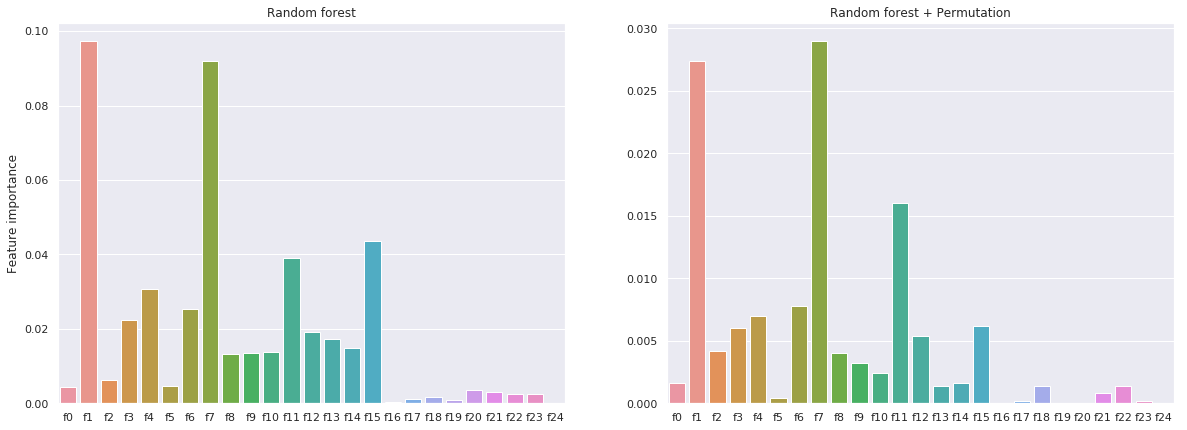

In [266]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(20, 7))
X, y = make_classification(n_samples=1000, n_features=250, n_informative=6, n_redundant=10, random_state=0, shuffle=False)

# fit a standard rf classifier
start = timeit.default_timer()
rf = RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)
rf.fit(X, y)
duration1 = timeit.default_timer() - start

# fit a rf classifier with permutation
start = timeit.default_timer()
perm = PermutationImportance(RandomForestClassifier(n_estimators=10, random_state=0), cv=None)
perm.fit(X, y)
duration2 = timeit.default_timer() - start

col = ['f'+str(i) for i in range(0,250)]
sns.barplot(x=col[:25], y=rf.feature_importances_[:25], ax=ax1)
ax1.set_title('Random forest')
ax1.set_ylabel('Feature importance')
sns.barplot(x=col[:25], y=perm.feature_importances_[:25], ax=ax2)
ax2.set_title('Random forest + Permutation')

In [267]:
print('Standard random forest duration: {}s'.format(round(duration1, 2)))
print('Random forest + permutation duration: {}s'.format(round(duration2, 2)))

Standard random forest duration: 0.11s
Random forest + permutation duration: 3.0s


In this example the 2 approaches seem to deliver very similar results but the processing time of the permutation approach is much higher than the standard approach.

### RFE approach
If several features are correlated, and the estimator uses them all equally, permutation importance can be low for all of these features: dropping one of the features may not affect the result, as estimator still has an access to the same information from other features. So if features are dropped based on importance threshold, such correlated features could be dropped all at the same time, regardless of their usefulness. RFE and alike methods (as opposed to single-stage feature selection) can help with this problem to an extent.

Recursive feature elimination is based on the idea to repeatedly construct a model and choose either the best or worst performing feature (for example based on coefficients), setting the feature aside and then repeating the process with the rest of the features. This process is applied until all features in the dataset are exhausted. Features are then ranked according to when they were eliminated. As such, it is a greedy optimization for finding the best performing subset of features.

In [269]:
from sklearn.feature_selection import RFE

X, y = make_classification(n_samples=1000, n_features=250, n_informative=6, n_redundant=10, random_state=0, shuffle=False)
rfe = RFE(RandomForestClassifier(n_estimators=10, random_state=0), 5)
rfe.fit(X, y)

s = rfe.ranking_
important_features = sorted(range(len(s)), key=lambda k: s[k])[:15]
print('Most important features: {}'.format(['f'+str(f) for f in important_features]))

Most important features: ['f1', 'f7', 'f11', 'f12', 'f15', 'f4', 'f10', 'f8', 'f0', 'f3', 'f6', 'f5', 'f14', 'f13', 'f71']


Although the importance value of the features is different from the previous methods, using RFE does not help to distinguish the informative features from the redundant ones and delivers the same overall result as the standard Random Forests and the Random Forests + permutation approach.

## Real dataset example
Lets now apply the above mentioned approaches to a real dataset and explore the differences in selected features and prediction accuracy.

In [271]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
df = pd.DataFrame(columns=data.feature_names, data=data.data)
df.shape

(569, 30)

Text(0.5,1,'6 informative feat - 14 uncorrelated')

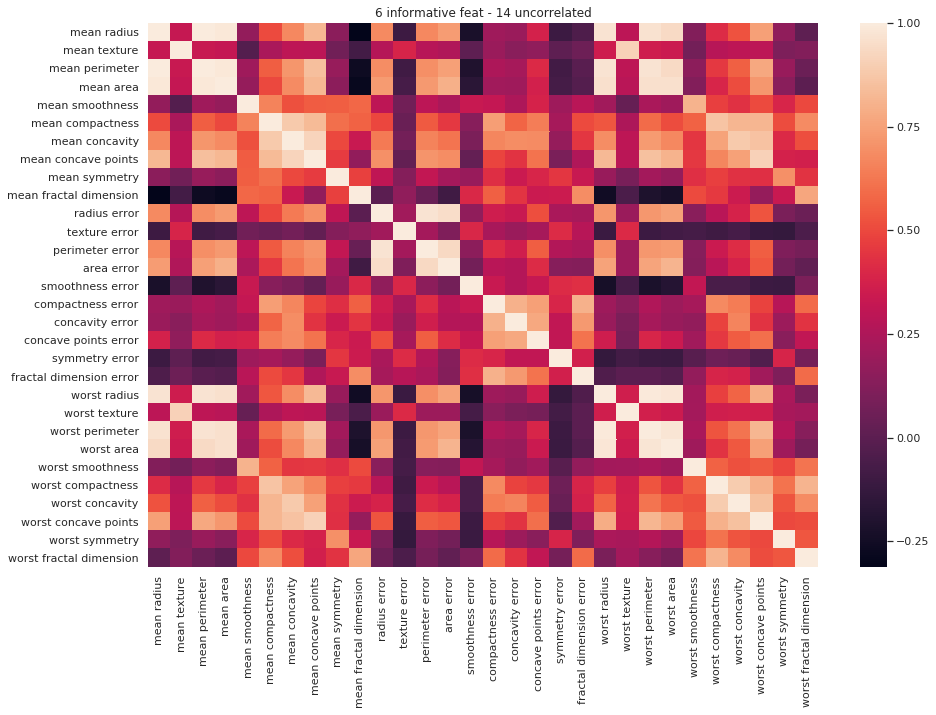

In [272]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 10))
sns.heatmap(df.corr(), ax=ax1)
ax1.set_title('6 informative feat - 14 uncorrelated')

The above plot highlights the degree of correlation of numerous features of the dataset.

In [273]:
X_train, X_test, y_train, y_test = train_test_split(df, data.target, test_size=0.3, random_state=0)
ntrees = 500
training_time = {}

# fit standard rf
start = timeit.default_timer()
rf = RandomForestClassifier(n_estimators=ntrees, n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)
training_time['rf_all'] = timeit.default_timer() - start
training_time['rf_important'] = training_time['rf_all']

# fit rf with permutation
start = timeit.default_timer()
perm = PermutationImportance(RandomForestClassifier(n_estimators=ntrees, random_state=0), cv=None)
perm.fit(X_train, y_train)
training_time['perm_important'] = timeit.default_timer() - start

# fit rf with RFE
start = timeit.default_timer()
rfe = RFE(RandomForestClassifier(n_estimators=ntrees, random_state=0), 5)
rfe.fit(X_train, y_train)
training_time['rfe_important'] = timeit.default_timer() - start

In [275]:
# find 5 most important features for all the above methods
def top_feat(feature_names, features_importance):
    important_index = sorted(range(len(features_importance)), key=lambda k: features_importance[k])[:5]
    return feature_names[important_index]

rfe_feat = top_feat(data.feature_names, rfe.ranking_)
rf_feat = top_feat(data.feature_names, rf.feature_importances_)
perm_feat = top_feat(data.feature_names, perm.feature_importances_)
print('RF important features: {}'.format(rf_feat))
print('RF + RFE important features: {}'.format(rfe_feat))
print('RF + permutation important features: {}'.format(perm_feat))

RF important features: ['mean fractal dimension' 'compactness error' 'smoothness error'
 'concave points error' 'fractal dimension error']
RF + RFE important features: ['mean concave points' 'worst radius' 'worst perimeter' 'worst area'
 'worst concave points']
RF + permutation important features: ['mean radius' 'mean perimeter' 'mean area' 'mean smoothness'
 'mean compactness']


All 3 methods deliver different features, lets test the accuracy of each of them to compare the results

In [248]:
from sklearn.metrics import accuracy_score

In [249]:
# test the accuracy of standard random forest
results = {}
prediction = rf.predict(X_test)
results['rf_all'] = accuracy_score(y_test, prediction)

In [250]:
# lets isolate the useful features for each method and retrain a rf classifier
models = {
    'rfe_important': rfe_feat,
    'perm_important': perm_feat,
    'rf_important': rf_feat
}
for model, features in models.items():
    # extract relevant features from train and test
    X_train_imp = X_train[features]
    X_test_imp = X_test[features]
    # fit the rf classifier using only important features
    start = timeit.default_timer()
    rf = RandomForestClassifier(n_estimators=ntrees, n_jobs=-1, random_state=0)
    rf.fit(X_train_imp, y_train)
    training_time[model] += timeit.default_timer() - start
    # predict on test subset
    prediction = rf.predict(X_test_imp)
    results[model] = accuracy_score(y_test, prediction)

In [251]:
print('** Classification accuracy **')
for model, accuracy in results.items():
    print('{}: {} | training time: {}s'.format(model, round(accuracy, 2), round(training_time[model], 2)))

** Classification accuracy **
rf_all: 0.96 | training time: 0.62s
rfe_important: 0.95 | training time: 16.31s
perm_important: 0.91 | training time: 6.69s
rf_important: 0.74 | training time: 1.26s


Lets keep in mind that the above training time keeps into consideration also the duration of the feature selection process.

Text(0.5,1,'Model accuracy')

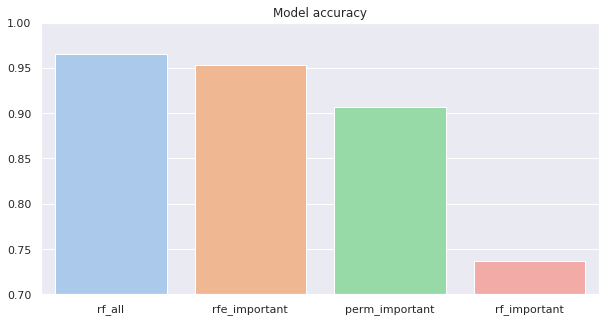

In [252]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
g = sns.barplot(x=list(results.keys()), y=list(results.values()), ax=ax1)
g.set(ylim=(0.7, 1))
ax1.set_title('Model accuracy')

As it can be seen the best performing model is the standard Random Forests which considers all the features. Among the reduced models, keeping only 5 features, the one using permutation is the best performing one and its accuracy is very close to the baseline.

In this specific example it may not be worth using Random Forests with permutation for feature selection since the dataset is very small and the training takes 20x as much time as the standard Random Forests approach. However in very big data science problems it may be worth investing more time in the feature selection process in order to perform the subsequent training in a reduced dataset.